### Import necessary libraries

In [1]:
import scipy.spatial
import numpy as np
import random
import cv2
import math
import time
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
import warnings

warnings.filterwarnings("ignore")

### Utility functions

In [3]:

def compute_color_probabilities(pixels, palette):
    distances = scipy.spatial.distance.cdist(pixels, palette)
    maxima = np.amax(distances, axis=1)

    distances = maxima[:, None] - distances
    summ = np.sum(distances, 1)
    distances /= summ[:, None]
    return distances

def get_color_from_prob(probabilities, palette, rand=False):
    probs = np.argsort(probabilities)
    i = probs[-1]
    if rand:
        r = random.uniform(0,1)
        if r<=0.1: i = probs[random.randint(max(0, probabilities.shape[0] - 3), probabilities.shape[0] - 1)]
    return palette[i]

def randomized_grid(h, w, scale):
    assert (scale > 0)

    r = scale//2

    grid = []
    for i in range(0, h, scale):
        for j in range(0, w, scale):
            y = random.randint(-r, r) + i
            x = random.randint(-r, r) + j

            grid.append((y % h, x % w))

    random.shuffle(grid)
    return grid


def limit_size(img, max_x, max_y=0):
    if max_x == 0:
        return img

    if max_y == 0:
        max_y = max_x

    ratio = min(1.0, float(max_x) / img.shape[1], float(max_y) / img.shape[0])

    if ratio != 1.0:
        shape = (int(img.shape[1] * ratio), int(img.shape[0] * ratio))
        return cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    else:
        return img

def get_color_palette(img, n=10, scale=200):
    # scale down the image to speedup kmeans
    img = limit_size(img, scale)

    clt = KMeans(n_clusters=n)
    clt.fit(img.reshape(-1, 3))

    return clt.cluster_centers_

def complement(colors):
    return 255 - colors

### Oil Painting Effect

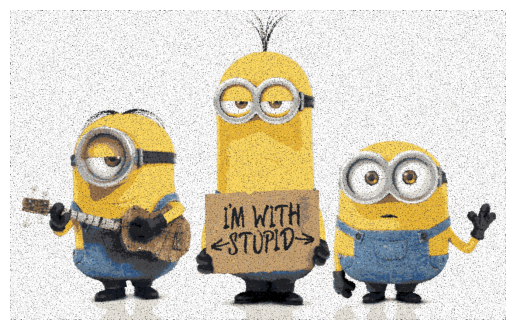

In [7]:
def apply_oil_painting_effect(image_path, primary_colors, rand=False):
    img = cv2.imread(image_path)
    radius_width = int(math.ceil(max(img.shape) / 1000))
    palette = get_color_palette(img, primary_colors)
    complements = complement(palette)
    palette = np.vstack((palette, complements))
    canvas = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    grid = randomized_grid(img.shape[0], img.shape[1], scale=3)
    pixel_colors = np.array([img[x[0], x[1]] for x in grid])
    color_probabilities = compute_color_probabilities(pixel_colors, palette)
    for i, (y, x) in enumerate(grid):
        color = get_color_from_prob(color_probabilities[i], palette, rand=rand)
        cv2.ellipse(canvas, (x, y), (radius_width, radius_width), 0, 0, 360, color, -1, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Usage
apply_oil_painting_effect('minion_gang.jpg', 10, rand=True)

### Black and White Sketch

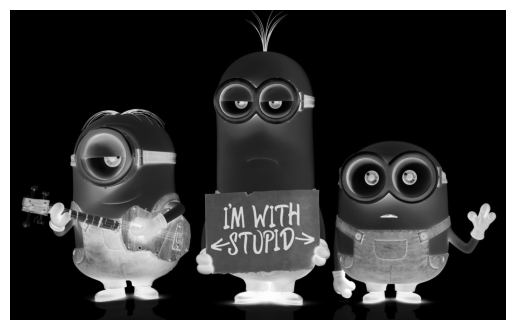

In [5]:
def create_colored_sketch(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_inv = cv2.bitwise_not(gray)
    colored_sketch = cv2.cvtColor(gray_inv, cv2.COLOR_GRAY2BGR)
    plt.imshow(cv2.cvtColor(colored_sketch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

create_colored_sketch('minion_gang.jpg')

### Colored Sketch

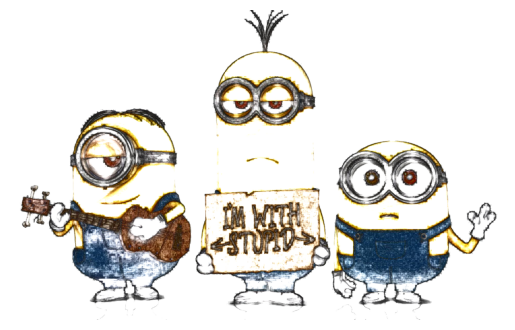

In [6]:
def create_colored_pencil_sketch(image_path):
    img = cv2.imread(image_path)
    dst_gray, dst_color = cv2.pencilSketch(img, sigma_s=60, sigma_r=0.07, shade_factor=0.05)
    plt.imshow(cv2.cvtColor(dst_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

create_colored_pencil_sketch('minion_gang.jpg')